In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import WeightedRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from visdom import Visdom
from callRate import plot_confusion_matrix, plot_ROC

plt.ion()   # interactive modeand

In [2]:
viz = Visdom(env='vgg16_weightedCE')
viz.line([[0.0, 0.0]], [0.], win='Train', opts=dict(title = 'Train',
                                                    legend = ['Loss', 'Accuracy'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    markers = [True, True],
                                                    markersymble = ['1', '1'],
                                                    markersize = 4))
viz.line([[0.0, 0.0]], [0.], win='Test', opts=dict(title='Test',
                                                    legend=['Loss', 'Accuracy'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    markers = [True, True],
                                                    markersymble = ['1', '1'],
                                                    markersize = 4))

viz.line([0.], [0.], win='B', opts=dict(title='Blistering', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='C', opts=dict(title='Crack', legend=[ 'Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='D', opts=dict(title='Delemination', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='G', opts=dict(title='Biological growth', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='N', opts=dict(title='No defects', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='P', opts=dict(title='Peeling', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))
viz.line([0.], [0.], win='S', opts=dict(title='Spalling', legend=['Accuracy'], xlabel = 'Epoch',
                                       linecolor=np.array([[225, 102, 102]]), markers = True, 
                                        markersymble=['1'], markersize=4))

Setting up a new session...


'S'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.5, 0.5, 0.5]),        
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.5, 0.5, 0.5])
    ]),
}

data_dir = 'exercise_data1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) 
                  for x in ['train', 'test']}

weights = [18.33, 6.85, 11.70, 66.25, 1, 4.01, 19.48] #weight on each class
class_sizes = [142, 381, 223, 39, 2610, 651, 134]
sampleWeights = [] #oversampling weight on each sample
for i in range(0, len(weights)):
    sampleWeights += [weights[i]]*class_sizes[i]

sampler = WeightedRandomSampler(sampleWeights, num_samples=len(sampleWeights), replacement = True)

oversampling = False

if oversampling:
    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=20,
                                                        sampler = sampler, num_workers=2),
                   'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=20,
                                                       shuffle=True, num_workers=2)}
else:
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                                  shuffle=True, num_workers=2)
                   for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print (class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

{'train': 4110, 'test': 350}
['B', 'C', 'D', 'G', 'N', 'P', 'S']


tensor([4, 6, 5, 4, 1, 5, 5, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 2, 4, 5])


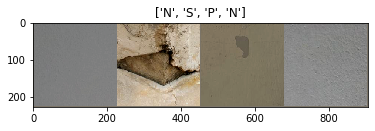

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs2 = inputs [:4]
classes2 = classes[:4]
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs2)
imshow(out, title=[class_names[x] for x in classes2])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        global_step += 1
        cm_labels = []
        cm_preds = []
        total_outputs = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            class_correct = list(0. for i in range(num_classes))
            class_total = list(0. for i in range(num_classes))
            class_acc = {} 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                           

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                if phase == 'test':
                    cm_labels += labels.tolist()
                    cm_preds += preds.tolist()
                    total_outputs += outputs.cpu().numpy().tolist()
                    res = preds.eq(labels)
                    for label_idx in range(len(labels)):
                        label_single = labels[label_idx]
                        class_correct[label_single] += res[label_idx].item()
                        class_total[label_single] += 1
                        
               
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels).float().sum().item()
                                
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                viz.line([[epoch_loss, epoch_acc]],[global_step],win = 'Train', update='append')
                
            if phase == 'test':
                viz.line([[epoch_loss,epoch_acc]],
                          [global_step], win = 'Test', update = 'append')
                for i in range(num_classes):
                    if class_total[i] == 0:
                        accuracy = 0
                    else:
                        accuracy = class_correct[i]/class_total[i]                        
                    class_acc[class_names[i]] = accuracy
                    viz.line([accuracy], [global_step], win = class_names[i], update = 'append')
                print(class_acc)
                
                
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
               
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_labels = cm_labels
                best_preds = cm_preds
                best_outputs = total_outputs
                best_model_wts = copy.deepcopy(model.state_dict())
            
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    plot_confusion_matrix(best_labels, best_preds, classes = class_names, normalize = True)
    fpr, tpr, precision, recall, f1, specificity = plot_ROC(best_labels, best_preds, best_outputs, class_names = class_names)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, fpr, tpr, precision, recall, f1,  best_labels, best_preds, best_outputs, specificity

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

# model_ft = nn.DataParallel(model_ft, device_ids=[1]) #multi-GPU
model_ft = model_ft.to(device)

#loss functions
# FL = FocalLoss(class_num = num_classes, gamma = 3) #focal loss

CE = nn.CrossEntropyLoss() #cross entropy loss

weights = [10, 2, 10, 40, 1, 2, 5] #weight on each class
weights = torch.Tensor(weights)
weights = weights.to(device)
CEW = nn.CrossEntropyLoss(weight = weights) #weighted cross entropy loss

criterion = CEW

# Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Epoch 0/49
----------
train Loss: 1.3811 Acc: 0.6825
{'B': 0.0, 'C': 0.68, 'D': 0.76, 'G': 0.06, 'N': 0.94, 'P': 0.64, 'S': 0.06}
test Loss: 2.9509 Acc: 0.4486
Epoch 1/49
----------
train Loss: 1.0435 Acc: 0.7647
{'B': 0.46, 'C': 0.8, 'D': 0.78, 'G': 0.28, 'N': 0.84, 'P': 0.34, 'S': 0.5}
test Loss: 1.3596 Acc: 0.5714
Epoch 2/49
----------
train Loss: 0.8646 Acc: 0.8080
{'B': 0.38, 'C': 0.74, 'D': 0.94, 'G': 0.42, 'N': 0.86, 'P': 0.56, 'S': 0.38}
test Loss: 1.2796 Acc: 0.6114
Epoch 3/49
----------
train Loss: 0.6969 Acc: 0.8338
{'B': 0.28, 'C': 0.9, 'D': 0.46, 'G': 0.52, 'N': 0.9, 'P': 0.48, 'S': 0.34}
test Loss: 1.5692 Acc: 0.5543
Epoch 4/49
----------
train Loss: 0.7291 Acc: 0.8360
{'B': 0.4, 'C': 0.92, 'D': 0.82, 'G': 0.62, 'N': 0.94, 'P': 0.6, 'S': 0.18}
test Loss: 1.2117 Acc: 0.6400
Epoch 5/49
----------
train Loss: 0.4274 Acc: 0.8891
{'B': 0.74, 'C': 0.86, 'D': 0.76, 'G': 0.46, 'N': 0.96, 'P': 0.72, 'S': 0.46}
test Loss: 1.5343 Acc: 0.7086
Epoch 6/49
----------
train Loss: 0.3439 

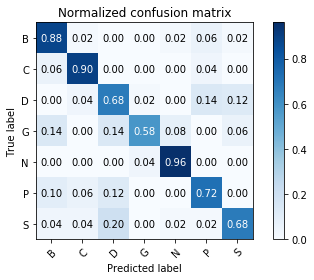

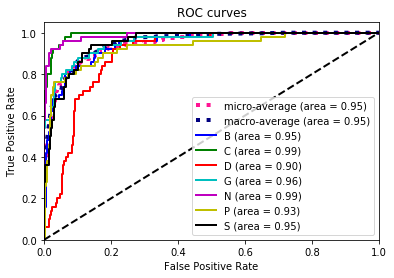

In [8]:
model, fpr, tpr, precision, recall, f1,  best_labels, best_preds, best_outputs, specificity = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

In [9]:
print('fpr: {0}'.format(fpr))
print('tpr: {0}'.format(tpr))
print('precision: {0}'.format(precision))
print('recall: {0}'.format(recall))
print('f1: {0}'.format(f1))
print('specificity: {0}'.format(specificity))

fpr: {0: array([0.        , 0.        , 0.        , 0.00666667, 0.00666667,
       0.01      , 0.01      , 0.01333333, 0.01333333, 0.02      ,
       0.02      , 0.02666667, 0.02666667, 0.04333333, 0.04333333,
       0.05333333, 0.05333333, 0.06      , 0.06      , 0.06333333,
       0.06333333, 0.07666667, 0.07666667, 0.09666667, 0.09666667,
       0.14      , 0.14      , 0.15      , 0.15      , 0.15333333,
       0.15333333, 0.18333333, 0.18333333, 0.21333333, 0.21333333,
       0.22333333, 0.22333333, 0.33666667, 0.33666667, 0.43666667,
       0.43666667, 1.        ]), 1: array([0.        , 0.        , 0.        , 0.00666667, 0.00666667,
       0.01      , 0.01      , 0.02      , 0.02      , 0.02333333,
       0.02333333, 0.02666667, 0.02666667, 0.04333333, 0.04333333,
       0.05666667, 0.05666667, 0.06333333, 0.06333333, 0.08      ,
       0.08      , 1.        ]), 2: array([0.        , 0.        , 0.        , 0.01333333, 0.01333333,
       0.01666667, 0.01666667, 0.02      , 0.02 